# Image denoising

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()
np.random.seed(40)

In [2]:
from tramp.models import DAGModel, MultiLayerModel
from tramp.base import SISOVariable, SIMOVariable, MILeafVariable
from tramp.likelihoods import GaussianLikelihood
from tramp.channels import DFTChannel, Blur2DChannel, GradientChannel, GaussianChannel
from tramp.priors import (
    GaussBernouilliPrior, BinaryPrior, GaussianPrior, MAP_L21NormPrior, MAP_LaplacePrior
)
from tramp.algos import (
    ExpectationPropagation, StateEvolution, 
    TrackEvolution, EarlyStopping, JoinCallback, 
    NoisyInit, ConstantInit
)

In [3]:
plt.rc("text", usetex=True)
logger.setLevel(logging.INFO)

In [4]:
def square_blob(shape, x, y):
    g = np.zeros(shape)
    g[x[0]:x[1], y[0]:y[1]] = 1.
    return g

def plot_data():
    fig, axs = plt.subplots(1,4,figsize=(12,3), sharey=True)
    axs[0].imshow(x, cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(x_grad[0], cmap="gray")
    axs[1].set(title=r"$(\nabla x)_0$")
    axs[2].imshow(x_grad[1], cmap="gray")
    axs[2].set(title=r"$(\nabla x)_1$")
    axs[3].imshow(y, cmap="gray")
    axs[3].set(title=r"$y$")
    fig.tight_layout()

def plot_prediction(r_pred):
    fig, axs = plt.subplots(1,3,figsize=(9, 3), sharey=True)
    axs[0].imshow(r_pred["x"], cmap="gray")
    axs[0].set(title=r"$x$")
    axs[1].imshow(r_pred["x'"][0], cmap="gray")
    axs[1].set(title=r"$(\nabla x)_0$")
    axs[2].imshow(r_pred["x'"][1], cmap="gray")
    axs[2].set(title=r"$(\nabla x)_1$")
    fig.tight_layout()
    
def compare_prediction(r_pred, u1=20):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=False)
    axs[0].plot(x[:,u1], label="true")
    axs[0].plot(r_pred["x"][:,u1], label="pred")
    axs[0].plot(y[:,u1], ".", label="y", color="gray", alpha=0.3)
    axs[0].legend()
    axs[0].set(title=r"$x$")
    axs[1].plot(x_grad[0,:,u1], label="true")
    axs[1].plot(r_pred["x'"][0,:,u1], label="pred")
    axs[1].legend()
    axs[1].set(title=r"$(\nabla x)_0$")
    fig.tight_layout()
    
def run_model(model, initializer=None):
    callback = EarlyStopping(tol=1e-6, min_variance=1e-15)
    ep = ExpectationPropagation(model)
    ep.iterate(max_iter=30, callback=callback, initializer=initializer)
    r_pred = {x_id: data["r"] for x_id, data in ep.get_variables_data().items()}
    v_pred = {x_id: data["v"] for x_id, data in ep.get_variables_data().items()}
    x_mse = mean_squared_error(x, r_pred["x"])  
    print(f"n_iter={ep.n_iter}")
    print(f"v_pred={v_pred}")
    print(f"x_mse={x_mse}")
    plot_prediction(r_pred)
    compare_prediction(r_pred, u1=20)

## Images

In [5]:
sblob = square_blob(
    (40, 50), x=(5, 10), y=(10, 15)
) + square_blob(
    (40, 50), x=(5, 15), y=(20, 40)
) + square_blob(
    (40, 50), x=(20, 35), y=(15, 45)
)

p_pos=0.3375 p_neg=0.6625
x_mean=-0.325 x_var=0.894
rho_grad=0.0425 var_grad=4.000


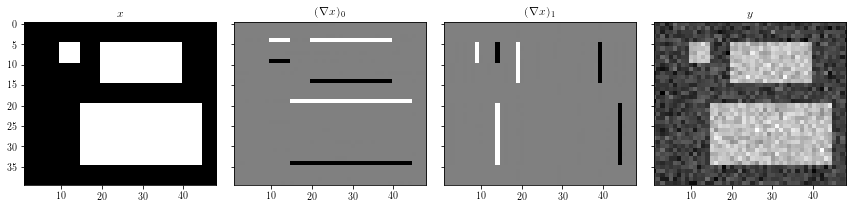

In [6]:
# signal 
var_noise = 0.1
x = 2*sblob - 1
x_shape = np.shape(x)
p_pos = (x==+1).mean()
p_neg = (x==-1).mean()
print(f"p_pos={p_pos} p_neg={p_neg}")
print(f"x_mean={x.mean()} x_var={x.var():.3f}")
# gradient
grad = GradientChannel(shape=x_shape)
x_grad = grad.convolve(x)
nonzero = np.abs(x_grad) > 1e-10
rho_grad = nonzero.mean()
var_grad = x_grad[nonzero].var()
print(f"rho_grad={rho_grad} var_grad={var_grad:.3f}")
# noise
y = x + np.sqrt(var_noise)*np.random.standard_normal(x_shape)

plot_data()

## Binary image denoising with informative prior

We use as prior information:
- $x$ is binary
- $\nabla x$ is sparse

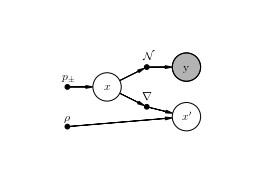

In [7]:
# sparse grad denoiser
grad_shape = (2,) + x_shape

sparse_grad_binary = (
    BinaryPrior(size=x_shape, p_pos=p_pos) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            GaussBernouilliPrior(size=grad_shape, var=var_grad, rho=rho_grad)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
sparse_grad_binary = DAGModel(sparse_grad_binary)
sparse_grad_binary.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:early stopping: min variance 1e-20
INFO:root:terminated after n_iter=5 iterations


n_iter=5
v_pred={'x': 9.9999999999999995e-21, "x'": 1.9999999999999996e-20}
x_mse=0.003999999999999998


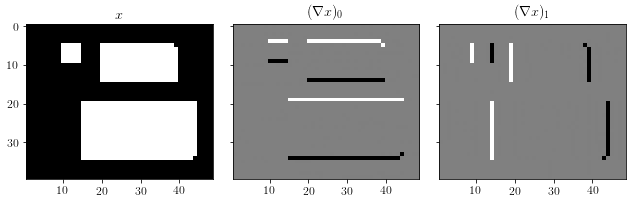

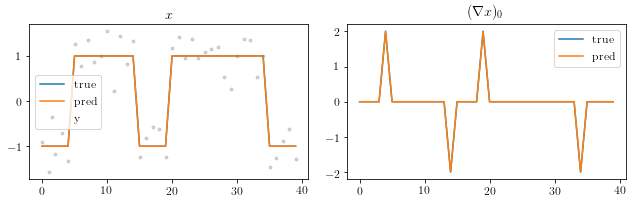

In [8]:
run_model(sparse_grad_binary)

## Binary image denoising with uninformative prior

We use as prior information:

- uninformative prior on $x$ (high variance Gaussian)
- $\nabla x$ is sparse

See if the sparsity of $\nabla x$ is enough to reconstruct the signal.

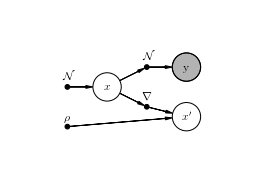

In [9]:
# sparse grad denoiser
large_var = 100
sparse_grad_gaussian = (
    GaussianPrior(size=x_shape, var=large_var) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            GaussBernouilliPrior(size=grad_shape, var=var_grad, rho=rho_grad)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
sparse_grad_gaussian = DAGModel(sparse_grad_gaussian)
sparse_grad_gaussian.daft()

INFO:root:init message dag with ConstantInit(a=0,b=0)
INFO:root:new_v=5.1380643151629555e-05>old_v=5.1371775762133995e-05 for SIMOVariable(n_prev=1,n_next=2,id=x)
INFO:root:terminated after n_iter=11 iterations


n_iter=11
v_pred={'x': 5.1371775762133995e-05, "x'": 1.6751858520125378e-06}
x_mse=0.027234806365891404


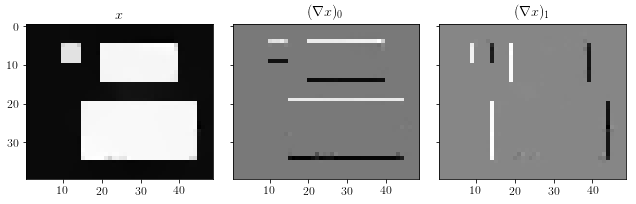

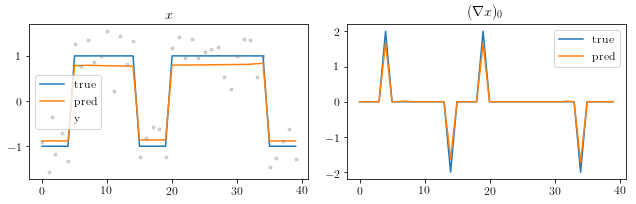

In [10]:
run_model(sparse_grad_gaussian)

## Total variation denoising

We use as prior information:

- uninformative prior on $x$ (high variance Gaussian)
- TV regularization on $\nabla x$

See if the TV regularization is enough to reconstruct the signal.

<div class="alert alert-warning">
We need to set initial conditions a=b=1. For a=b=0 ExpectationPropagation diverges.
</div>


/Users/antoinebaker/Documents/projects/ml_physics/tramp/priors/map_L21_norm_prior.py:26: UserWarning: MAP_L21NormPrior.sample not implemented return zero array as a placeholder
  "MAP_L21NormPrior.sample not implemented "
/Users/antoinebaker/Documents/projects/ml_physics/tramp/priors/map_L21_norm_prior.py:36: UserWarning: MAP_L21NormPrior.second_moment not implemented return 1 as a placeholder
  "MAP_L21NormPrior.second_moment not implemented "


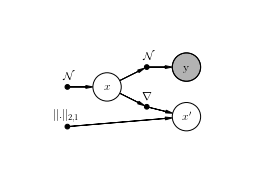

In [11]:
# hyperparam
scale_grad = 1
# sparse grad denoiser
tv_denoiser = (
    GaussianPrior(size=x_shape, var=100) @
    SIMOVariable(id="x", n_next=2) @ (
        GaussianLikelihood(y=y, var=var_noise) + (
            GradientChannel(shape=x_shape) +
            MAP_L21NormPrior(size=grad_shape, scale=scale_grad)
        ) @
        MILeafVariable(id="x'", n_prev=2)
    )
).to_model_dag()
tv_denoiser = DAGModel(tv_denoiser)
tv_denoiser.daft()

INFO:root:init message dag with ConstantInit(a=1,b=1)
INFO:root:new_v=0.04906532961747042>old_v=0.04877779818883416 for SIMOVariable(n_prev=1,n_next=2,id=x)
INFO:root:terminated after n_iter=7 iterations


n_iter=7
v_pred={'x': 0.048777798188834161, "x'": 0.08445067829350944}
x_mse=0.03289366403556495


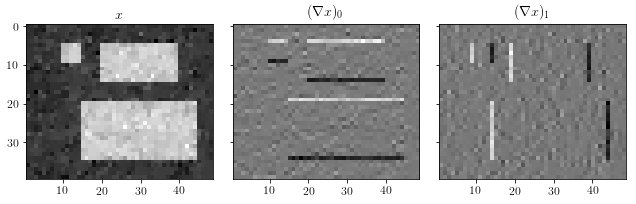

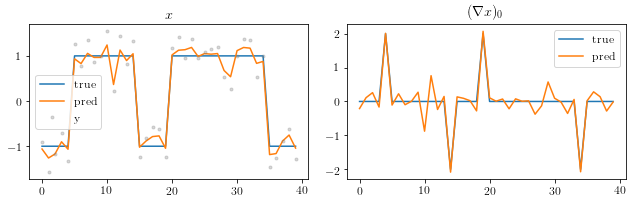

In [12]:
run_model(tv_denoiser, initializer=ConstantInit(a=1, b=1))